## Промышленность — задача проекта

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. Вам предстоит построить модель, которая предскажет температуру стали.

#### Описание этапа обработки

Сталь обрабатывают в металлическом ковше вместимостью около 100 тонн. Чтобы ковш выдерживал высокие температуры, изнутри его облицовывают огнеупорным кирпичом. Расплавленную сталь заливают в ковш и подогревают до нужной температуры графитовыми электродами. Они установлены в крышке ковша. 

Из сплава выводится сера (десульфурация), добавлением примесей корректируется химический состав и отбираются пробы. Сталь легируют — изменяют её состав — подавая куски сплава из бункера для сыпучих материалов или проволоку через специальный трайб-аппарат (англ. tribe, «масса»).

Перед тем как первый раз ввести легирующие добавки, измеряют температуру стали и производят её химический анализ. Потом температуру на несколько минут повышают, добавляют легирующие материалы и продувают сплав инертным газом. Затем его перемешивают и снова проводят измерения. Такой цикл повторяется до достижения целевого химического состава и оптимальной температуры плавки.

Тогда расплавленная сталь отправляется на доводку металла или поступает в машину непрерывной разливки. Оттуда готовый продукт выходит в виде заготовок-слябов (англ. *slab*, «плита»).

#### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

In [1]:
# Импорт библиотек
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
import random
import math

from pyod.models.knn import KNN
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from catboost import CatBoostRegressor
from catboost import Pool, cv

import lightgbm

# Настройки.
pd.set_option('display.max_columns', None)
sns.set(rc={'figure.figsize':(12, 9)})
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [2]:
# Загрузка данных.
df_arc = pd.read_csv('data_arc.csv')
df_bulk_time = pd.read_csv('data_bulk_time.csv')
df_bulk = pd.read_csv('data_bulk.csv')
df_gas = pd.read_csv('data_gas.csv')
df_temp = pd.read_csv('data_temp.csv')
df_wire_time = pd.read_csv('data_wire_time.csv')
df_wire = pd.read_csv('data_wire.csv')

## Функции для первичного анализа данных

In [3]:
# Получение общей информации о датасете.
def get_info(data):
    display(data.head())
    display(data.describe())
    data.info()    

In [4]:
# Получение списка фичей.
def get_features_list(data, exceptions=None):
    features_list = data.columns.drop(exceptions)
    return features_list

In [5]:
# Настройка параметров гистограммы распределения.
def get_hist_settings(features_list):
    len_features_list = len(features_list)
    
    columns = 3
    rows = round(len_features_list / columns)
    figsize = (16,20)
        
    if len_features_list <= 3:
        columns = 2
        rows = 1
        figsize = (16,6)
        
    return columns, rows, figsize

In [6]:
# Построение гистограммы.
def get_histplot(data, exceptions='key', binrange=None):
    features_list = get_features_list(data, exceptions)
    columns, rows, figsize = get_hist_settings(features_list)
    
    fig, axes = plt.subplots(rows, columns, figsize=figsize)
    axes = axes.flatten()
    
    for ax, feature in zip(axes, features_list):
        sns.histplot(data[feature], ax=ax, binrange=binrange)
        plt.suptitle('Распределение признаков', fontsize=20)
        ax.set_ylabel('Кол-во наблюдений')

    if len(features_list) == 1:
        fig.delaxes(axes[1])
    
    plt.show()  

In [7]:
# Построение тепловой карты корреляции.
def get_correlation_map(data):
    sns.heatmap(data.corr(), cmap="Blues", annot=True)
    plt.title('Тепловая карта корреляции', fontsize=18, pad=20)
    plt.show()

In [8]:
# Построение диаграммы размаха.
def get_boxplot(data, column):
    sns.boxplot(x=data[column])
    plt.title('Диаграмма размаха', fontsize=18, pad=20)
    plt.show()

In [9]:
# Рассчет границы правого выброса.
def right_outlier(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    r_outlier = data[data[column] > Q3 + 1.5 * IQR][column].min()
    return r_outlier

In [10]:
# Рассчет границы левого выброса.
def left_outlier(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    
    l_outlier = data[data[column] < Q1 - 1.5 * IQR][column].max()
    return l_outlier

In [11]:
# Рассчет границы экстремального правого выброса.
def right_extreme_outlier(data):
    right_extreme_outlier_dic = {}
    for column in data.columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        
        r_outlier = data[data[column] > Q3 + 3 * IQR][column].min()
        right_extreme_outlier_dic[column] = r_outlier

    return right_extreme_outlier_dic

In [12]:
# Рассчет границы экстремального левого выброса.
def left_extreme_outlier(data):
    left_extreme_outlier_dic = {}
    for column in data.columns:
        Q1 = data[column].quantile(0.25)
        Q3 = data[column].quantile(0.75)
        IQR = Q3 - Q1
        
        l_outlier = data[data[column] < Q1 - 3 * IQR][column].max()
        left_extreme_outlier_dic[column] = l_outlier

    return left_extreme_outlier_dic

In [13]:
# Проверка датасета на пропущенные значения в партиях.
def check_missing_batches(data):
    return set((set(range(1, 3242))) - set(data['key']))

## Функции для предобработки данных

In [14]:
# Конвертация времени в формат datetime.
def convert_to_datetime(data, columns):
    for column in columns:
        data[column] = pd.to_datetime(data[column], format=('%Y-%m-%dT%H:%M:%S'))
        print(f'Проверка: {data[column].dtype}')

In [15]:
# Функция для удаления "бракованных" партий из датасетов.
def del_batches(data, list_to_remove):
    for bath in list_to_remove:
        if bath in data.index:
            data = data.drop(index=bath)
    return data       

In [16]:
# Функция установки индекса.
def set_new_index(data):
    data = data.set_index('key')
    data.index.name = None
    return data

In [17]:
# Функция разделения датасета на трейн и тест.
def data_preparation(data):
    
    # Разделение обучающих и целевого признака.
    features = data.drop('last_temp', axis=1) 
    target = data['last_temp']
    
    # Разделение на обучающую и валидационные выборки.
    X_train, X_test, y_train, y_test = (
        train_test_split(features, 
                         target, 
                         test_size=0.25, 
                         random_state=42)
    )
    return X_train, X_test, y_train, y_test

## Функции для обучения и анализа результата обучения

In [18]:
# Функция построения графика наиболее значимых признаков.
def barplot_feature_importance(importance, names, model):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    feature_importance_dic = {'feature_names':feature_names,
                             'feature_importance':feature_importance}
    df_feature_importance = pd.DataFrame(feature_importance_dic)
    df_feature_importance.sort_values(by=['feature_importance'], ascending=False, inplace=True)
    
    plt.figure(figsize=(12,10))
    sns.barplot(x=df_feature_importance['feature_importance'], 
                y=df_feature_importance['feature_names'])
    
    plt.title('Значимые признаки', fontsize=18, pad=20)
    plt.xlabel('Значения')
    plt.ylabel('Признаки')

## Первичный анализ данных

### План решения задачи

Перед нами стоит задача построить регрессионную модель, которая будет предсказывать последнюю температуру. В первом приближении из наших датасетов невозможно сформировать цикл, описанный в условиях задачи. Так в них говорится, что алгоритм легирования происходит следующими образом: замер температуры, нагрев ковша, добавление сыпучих материалов, проволоки, продувка газом, замер температуры. В данных, которые у нас есть, замеры температуры производится как до включения дуги, так и после, как до добавления легирующих материалов так и после. У нас нет возможности уточнить особенности процесса легирования у заказчика, поэтому мы будем исходить из того, что в каждой партии нам дан один цикл легирования. Следовательно, целевым признаком станет последняя температура в каждой партии.  

Корректность целевого признака мы будем проверять, сравнивая время последнего замера температуры и время последнего добавления в сплав легирующих материалов.  
    
Так как нам необходимо найти зависимость конечной температуры от объема добавленных в сплав легирующих материалов, на наш взгляд, будет верным ввести в обучающие данные дополнительный признак: "начальное состояние системы", которое будет выраженно значением температуры перед нагреванием и добавлением легирующих материалов. В нашем случае, первым значением температуры в партии.

### Датасет df_temp

In [19]:
# Загрузим общую информацию.
get_info(df_temp)

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0


,key,Температура
count,15907.000000,13006.000000
mean,1607.880870,1591.840920
std,942.212073,21.375851
min,1.000000,1191.000000
25%,790.000000,1581.000000
50%,1618.000000,1591.000000
75%,2427.000000,1601.000000
max,3241.000000,1705.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   key           15907 non-null  int64  
 1   Время замера  15907 non-null  object 
 2   Температура   13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB


In [20]:
len(df_temp['key'].unique())

3216

In [21]:
# Вызовем функцию проверки партий с пропущенными значениями.
temp_missing_batches_set = check_missing_batches(df_temp)
len(temp_missing_batches_set)

25

Датасет df_temp имеет ключевое значение в исследовании. По нему мы будем формировать целевой признак. Известно, что целевой признак -- это последняя измеренная температура.  

Мы видим, что в датасете 2901 пропуск в признаке "Температура". Это чуть более 18%. Нельзя исключать, что пропуски могут быть в измерениях последней температуры. Такие пропуски нам будет необходимо найти, а партии с этими пропусками -- удалить.  

В датасете содержатся данные только о 3216 партиях, т.е. отсутствуют данные о 25 партиях. 

Приведем признак "Время замера" к типу datetime[64] для дальнейшго анализа.

In [22]:
# Вызовем функцию конвертации типа данных.
convert_to_datetime(df_temp, ['Время замера'])

Проверка: datetime64[ns]


Посмотрим на распределение значений и выбросы.

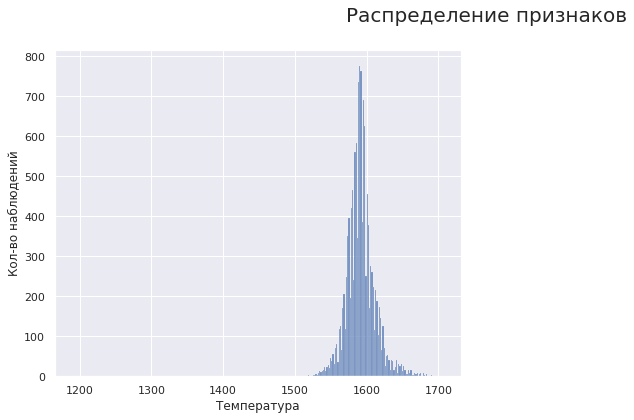

In [23]:
# Вызовем функцию построения гистограммы.
exceptions = ['key', 'Время замера']
get_histplot(df_temp, exceptions)

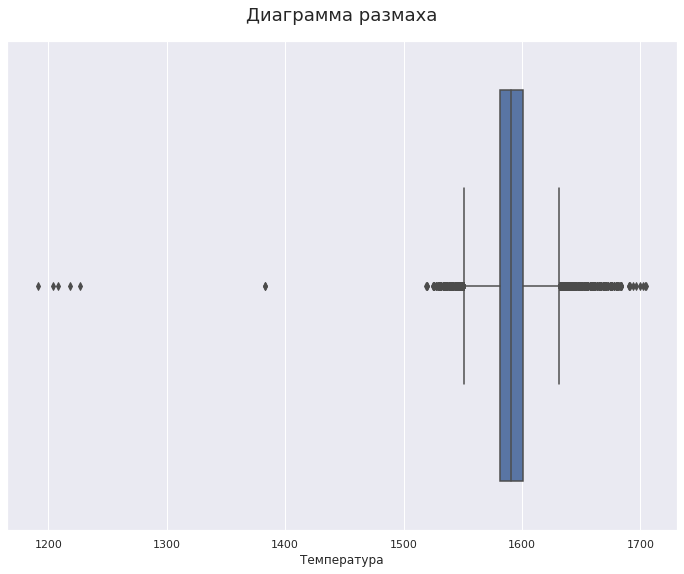

In [24]:
# Вызовем функцию построения диграммы размаха.
get_boxplot(df_temp, 'Температура')

In [25]:
# Вызовем функции определения границ правого и левого выбросов.
print(f'Граница левого выброса: {left_outlier(df_temp, "Температура")}')
print(f'Граница правого выброса: {right_outlier(df_temp, "Температура")}')

Граница левого выброса: 1550.0
Граница правого выброса: 1632.0


In [26]:
# Рассчитываем выбросы.
left_temp_tail = df_temp[df_temp["Температура"] <= 1550]["Температура"].count()
right_temp_tail = df_temp[df_temp["Температура"] >= 1632]["Температура"].count()
sum_temp_outlier = left_temp_tail + right_temp_tail

print(f'Длина левого хвоста: {left_temp_tail}')
print(f'Длина правого хвоста: {right_temp_tail}')
print(f'Суммарное количество выбросов: {sum_temp_outlier}')

Длина левого хвоста: 248
Длина правого хвоста: 475
Суммарное количество выбросов: 723


На гистограмме мы видим правый и левый хвост. Левый длинный до значения 1200 градусов. С учетом границ в выбросы попали 723 наблюдения, почти 6% датасета. При этом правых выбросов в два раза больше, чем левых. Т.е. условный "перегрев" ковша встречается чаще.  

Нам известно, что температура плавления стали находится в диапазоне от 1350 до 1535°С. При этом мы видим значения температуры ниже 1350°С. Т.е. или в этот момент сплав застывал в ковше, или мы имеем дело с некорректными данными.

Правый выброс - более интересный. Его значение на 1000 градусов превышает справочную температуру плавления стали.

Рассчитаем выбросы по формуле Q3 + 3 \* IQR и Q1 - 3 \* IQR, чтобы увидеть наиболее экстремальные значения.

In [27]:
pd.DataFrame.from_dict(right_extreme_outlier(df_temp), # вызываем функцию рассчета экстремальных выбросов
                       orient='index', 
                       columns=['Экстремальный правый выборос'])
                      

,Экстремальный правый выборос
key,NaN
Время замера,NaT
Температура,1662.0


In [28]:
pd.DataFrame.from_dict(left_extreme_outlier(df_temp), # вызываем функцию рассчета экстремальных выбросов
                       orient='index', 
                       columns=['Экстремальный левый выборос'])

,Экстремальный левый выборос
key,NaN
Время замера,NaT
Температура,1520.0


Граница экстремального левого выброса приходится на температуру 1520°С. Это выше температуры, при которой сталь плавится, поэтому установим значение нижнего порога по справочнику - 1350°С.

In [29]:
# Рассчитываем выбросы.
left_temp_tail = df_temp[df_temp["Температура"] <= 1350]["key"].count()
right_temp_tail = df_temp[df_temp["Температура"] >= 1662]["key"].count()
sum_temp_outlier = left_temp_tail + right_temp_tail

print(f'Длина левого хвоста: {left_temp_tail}')
print(f'Длина правого хвоста: {right_temp_tail}')
print(f'Суммарное количество выбросов: {sum_temp_outlier}')

Длина левого хвоста: 5
Длина правого хвоста: 85
Суммарное количество выбросов: 90


Зафиксируем партии с экстремальными выбросами.

In [30]:
temp_outliers_set = (set(df_temp[df_temp["Температура"] <= 1350]["key"]) |
                    set(df_temp[df_temp["Температура"] >= 1662]["key"])
                    )

Теперь нам необходимо проверить, есть ли в датасете партии, у которых значение последнего и первого измерения температуры NaN.

In [31]:
df_temp = df_temp.rename(columns={'Время замера': 'time',
                                  'Температура': 'temp'})

In [32]:
last_temp_is_nan_list = [] # список партий с отсутствующей последней температурой
first_temp_is_nan_list = [] # список партий с отсутствующей первой температурой

for key in df_temp['key'].unique(): 

    last_temp = df_temp[df_temp['key'] == key]['temp'].values[-1]
    first_temp = df_temp[df_temp['key'] == key]['temp'].values[0]
        
    if np.isnan(last_temp): # ищем NaN в последней записи
        last_temp_is_nan_list.append(key) # добавляем партию в список
        
    if np.isnan(first_temp): # ищем NaN в первой записи
        first_temp_is_nan_list.append(key) # добавляем партию в список

print(len(last_temp_is_nan_list))
print(len(first_temp_is_nan_list))

739
0


Партий, в который нет последнего значения температуры - 739, более 5% датасета. Считаем, что восстанавливать целевые признаки будет неправильным решением, так как в условиях реального заказа, мы бы запросили эти данные у заказчика. Получить их на производстве не представляет труда. Восстановление недостающих значений, на наш взгляд, отразится на качестве модели. И хотя объем пропущенных значений превышает 5%, в данной работе мы их удалим. 

In [33]:
# Сгруппируем данные по партиям.
min_time = df_temp.groupby('key')['time', 'temp'].agg(lambda x: x.iloc[0]).reset_index()
max_time = df_temp.groupby('key')['time', 'temp'].agg(lambda x: x.iloc[-1]).reset_index()

# Переименуем столбцы.
min_time = min_time.rename(columns={'time': 'min_time', 'temp': 'first_temp'})
max_time = max_time.rename(columns={'time': 'max_time', 'temp': 'last_temp'})

# Установим номер партии в качестве индекса.
min_time = set_new_index(min_time)
max_time = set_new_index(max_time)

# Объединим данные в одну таблицу.
min_max_temp = min_time.join(max_time)
min_max_temp.head(3)

/tmp/ipykernel_12182/1590522637.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  min_time = df_temp.groupby('key')['time', 'temp'].agg(lambda x: x.iloc[0]).reset_index()
/tmp/ipykernel_12182/1590522637.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  max_time = df_temp.groupby('key')['time', 'temp'].agg(lambda x: x.iloc[-1]).reset_index()


,min_time,first_temp,max_time,last_temp
1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0
2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0
3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0


Удалим из таблицы те партии, в которых значение последней температуры было NaN.

In [34]:
# Вызовем функцию удаления "бракованных" партий.
min_max_temp = del_batches(min_max_temp, last_temp_is_nan_list)
len(min_max_temp)

2477

Проведем дополнительную проверку. Узнаем, сколько наблюдений после удаления данных, сохранили экстремальные значения. 

In [35]:
min_max_temp[(min_max_temp["first_temp"] <= 1350) |
             (min_max_temp["first_temp"] >= 1662)]["first_temp"].count()

11

In [36]:
min_max_temp[(min_max_temp["last_temp"] <= 1350) |
             (min_max_temp["last_temp"] >= 1662)]["last_temp"].count()

25

Экстремальные значения находятся в 36 партиях. Удалим их.

In [37]:
min_max_temp = min_max_temp[(min_max_temp["first_temp"] >= 1350) &
                            (min_max_temp["first_temp"] <= 1662)]

min_max_temp = min_max_temp[(min_max_temp["last_temp"] >= 1350) &
                            (min_max_temp["last_temp"] <= 1662)]

len(min_max_temp)

2445

### Датасет df_arc

In [38]:
# Загрузим общую информацию.
get_info(df_arc)

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397


,key,Активная мощность,Реактивная мощность
count,14876.000000,14876.000000,14876.000000
mean,1615.220422,0.670441,0.452592
std,934.571502,0.408159,5.878702
min,1.000000,0.030002,-715.504924
25%,806.000000,0.395297,0.290991
50%,1617.000000,0.555517,0.415962
75%,2429.000000,0.857034,0.637371
max,3241.000000,3.731596,2.676388


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB


Датасет без пропусков. Определим, сколько было произведено партий металла.

In [39]:
len(df_arc['key'].unique())

3214

Датасет содержит данные об 3214 партиях. В датасете отсутствуют данные о нагреве в 27 партиях. Внесем их в множество партий, в которых отсутствуют данные.

In [40]:
# Вызовем функцию проверки партий с пропущенными значениями.
arc_missing_batches_set = check_missing_batches(df_arc)
len(arc_missing_batches_set)

27

Обращает на себя внимание минимальное значение признака "Реактивная мощность" - (-715.5). По законам физики, реактивная мощность может принимать отрицательные значения. Узнаем, сколько отрицательных значений этого признака в датасете.

In [41]:
df_arc[df_arc['Реактивная мощность'] < 0]['Реактивная мощность']

9780   -715.504924
Name: Реактивная мощность, dtype: float64

В датасете это **единственное** значение, а следовательно с высокой долей вероятности, оно было получено в результате како-либо сбоя. Посмотрим на распределение признаков 'Реактивная мощность', 'Активная мощность'.  

Так как отрицательное значение "Реактивной мощности" у нас только одно укажем диапозон от 0 до максимального значения в признаке "Активная мощность" - 3.73

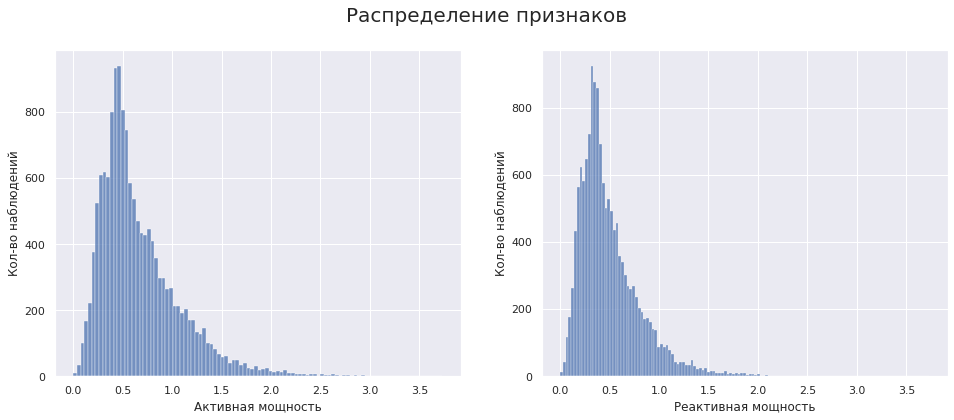

In [42]:
# Вызовем функцию построения гистограммы.
exceptions = ['key', 'Начало нагрева дугой', 'Конец нагрева дугой']
binrange = (0, 3.73)
get_histplot(df_arc, exceptions, binrange)

У признаков "Активная мощность" и "Реактивная мощность" заметны длинные правые хвосты. Построим график "ящик с усами", чтобы посмотреть на возможные выбросы. 

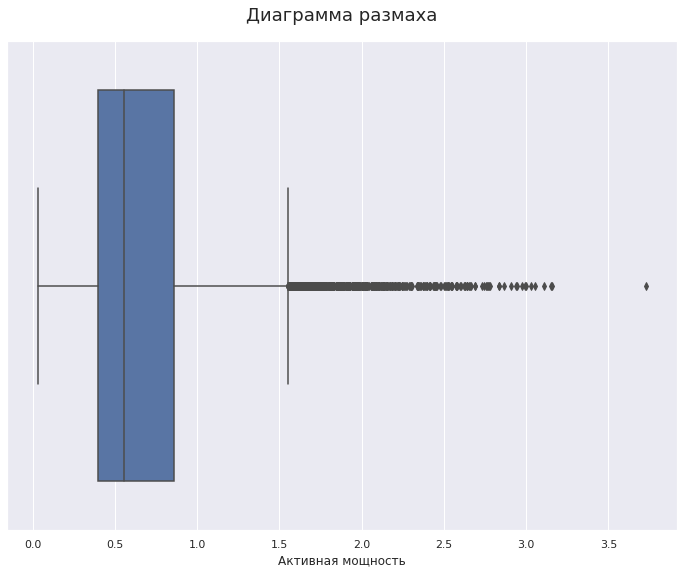

In [43]:
# Вызовем функцию построения диаграммы размаха.
get_boxplot(df_arc, 'Активная мощность')

Так как значение "Реактивной мощности" -715.50 с большой долей вероятности является ошибкой, удалим его из датасета. И построим диаграмму размаха для признака "Реактивная мощность".

In [44]:
df_arc = df_arc[df_arc['Реактивная мощность'] > 0]

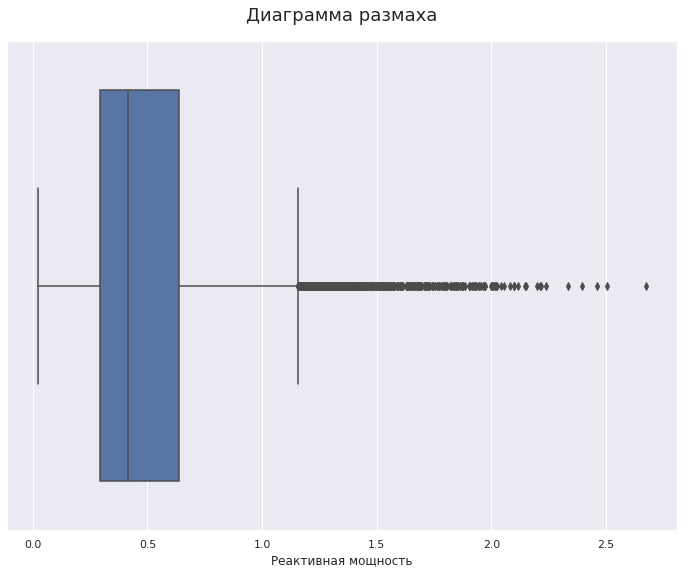

In [45]:
# Вызовем функцию построения диаграммы размаха.
get_boxplot(df_arc, 'Реактивная мощность')

Диаграммы рахмаха подвердили выборосы в признаке "Активная мощность" в районе 1.5 единиц и  "Реактивная мощность" в районе 1.2 единиц. Данные выбросы могут появляться в результате технологического процесса, а поэтому нам необходимо их сохранить, чтобы наша модель обучалась на полных данных. Посмотрим, как эти выбросы связаны со времением подогрева сплава графитовыми электродами.  

Переведем признаки "Начало нагрева дугой" и "Конец нагрева дугой" в формат datetime64.	

In [46]:
# Вызовем функцию конвертации типа данных.
convert_to_datetime(df_arc, ['Начало нагрева дугой', 'Конец нагрева дугой'])

Проверка: datetime64[ns]
Проверка: datetime64[ns]


Рассчитаем время нагрева. И переведем его в секунды.

In [47]:
df_arc['delta'] = df_arc['Конец нагрева дугой'] - df_arc['Начало нагрева дугой']
df_arc['delta_seconds'] = df_arc['delta'].astype('timedelta64[s]')
df_arc['delta_seconds'].head(5)

0    228.0
1    185.0
2    172.0
3    365.0
4    148.0
Name: delta_seconds, dtype: float64

Посмотрим на распределение времени нагрева и на возможные выборосы.

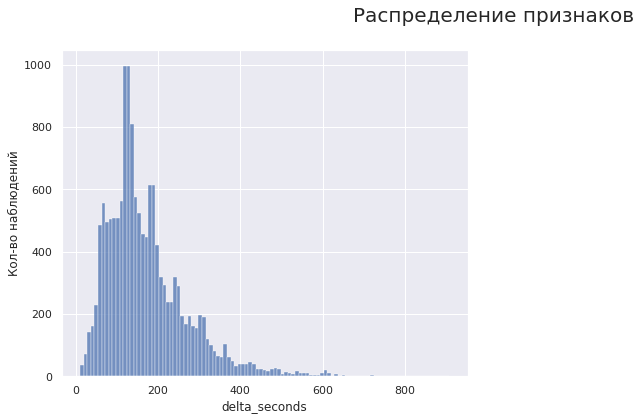

In [48]:
# Вызовем функцию построения гистограммы.
exceptions = ['key', 
              'Начало нагрева дугой', 
              'Конец нагрева дугой', 
              'Активная мощность', 
              'Реактивная мощность', 
              'delta']
get_histplot(df_arc, exceptions)

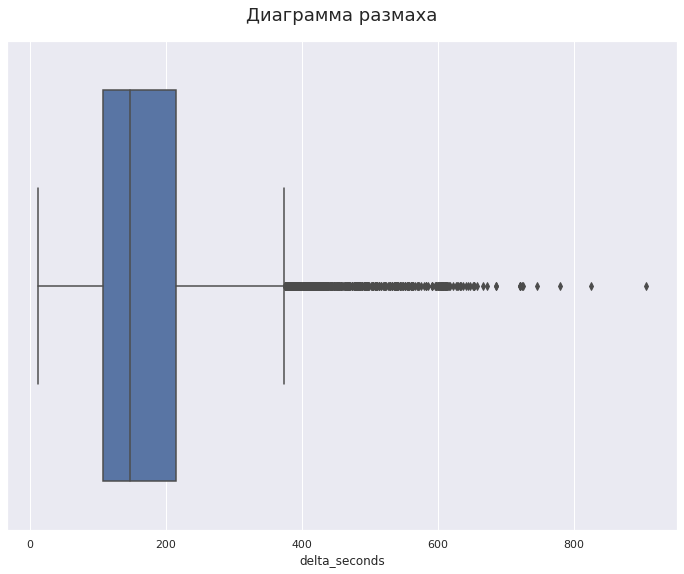

In [49]:
# Вызовем функцию построения диаграммы размаха.
get_boxplot(df_arc, 'delta_seconds')

Мы видим ассимитричное распределение, длинный правый хвост. И выбросы по диаграмме размаха в районе 400 секунд. Уточним значения границы выбросов по межквартильному размаху.

In [50]:
print(f'Граница выброса в признаке "Активная мощность": {right_outlier(df_arc, "Активная мощность")}')
print(f'Граница выброса в признаке "Реактивная мощность": {right_outlier(df_arc, "Реактивная мощность")}')
print(f'Граница выброса в признаке "delta_seconds": {right_outlier(df_arc, "delta_seconds")}')

Граница выброса в признаке "Активная мощность": 1.5496923327
Граница выброса в признаке "Реактивная мощность": 1.1572875977
Граница выброса в признаке "delta_seconds": 375.0


Посмотрим на количество выбросов в признаках "delta_seconds", "Активная мощность" и "Реактивная мощность". 

In [51]:
arc_seconds_outliers = df_arc[df_arc['delta_seconds'] >= 375]['delta_seconds'].count()
arc_active_power_outliers = df_arc[df_arc['Активная мощность'] >= 1.54]['Активная мощность'].count()
arc_reactive_power_outliers = df_arc[df_arc['Реактивная мощность'] >= 1.15]['Реактивная мощность'].count()

print(f'Количество выбросов в признаке delta_seconds: {arc_seconds_outliers}')
print(f'Количество выбросов в признаке Активная мощность: {arc_active_power_outliers}')
print(f'Количество выбросов в признаке Реактивная мощность: {arc_reactive_power_outliers}')

Количество выбросов в признаке delta_seconds: 617
Количество выбросов в признаке Активная мощность: 584
Количество выбросов в признаке Реактивная мощность: 612


Нам неизвестна причина, по которой сплав в 617 циклах нагревался дольше, чем обычно. Обратимся к формуле 3Q + 3\*IQR, чтобы посмотреть на экстремальные выбросы.

In [52]:
pd.DataFrame.from_dict(right_extreme_outlier(df_arc), # вызываем функцию рассчета экстремальных выбросов
                       orient='index', 
                       columns=['Экстремальный правый выборос'])

,Экстремальный правый выборос
key,NaN
Начало нагрева дугой,NaT
Конец нагрева дугой,NaT
Активная мощность,2.24348
Реактивная мощность,1.677173
delta,0 days 00:08:56
delta_seconds,536.0


In [53]:
arc_seconds_outliers = df_arc[df_arc['delta_seconds'] >= 536]['delta_seconds'].count()
arc_active_power_outliers = df_arc[df_arc['Активная мощность'] >= 2.24348]['Активная мощность'].count()
arc_reactive_power_outliers = df_arc[df_arc['Реактивная мощность'] >= 1.677173]['Реактивная мощность'].count()

print(f'Количество экстремальных выбросов в признаке delta_seconds: {arc_seconds_outliers}')
print(f'Количество экстремальных выбросов в признаке Активная мощность: {arc_active_power_outliers}')
print(f'Количество экстремальных выбросов в признаке Реактивная мощность: {arc_reactive_power_outliers}')

Количество экстремальных выбросов в признаке delta_seconds: 121
Количество экстремальных выбросов в признаке Активная мощность: 93
Количество экстремальных выбросов в признаке Реактивная мощность: 115


Зафиксируем номера партий, в который мы обнаружили экстремальные выбросы.

In [54]:
arc_outliers_set = (set(df_arc[df_arc['delta_seconds'] >= 536]["key"]) |
                    set(df_arc[df_arc['Активная мощность'] >= 2.24348]["key"]) |
                    set(df_arc[df_arc['Реактивная мощность'] >= 1.677173]["key"])
                    )

Найдем партии внутри которых есть выбросы во всех трех признаках.

In [55]:
arc_outliers_list = df_arc[(df_arc['delta_seconds'] >= 536) &
                           (df_arc['Активная мощность'] >= 2.24348) &
                           (df_arc['Реактивная мощность'] >= 1.677173)]['key']

print(f'Количество партий, в которых есть выбросы во всех признаках: {len(arc_outliers_list.unique())}')

Количество партий, в которых есть выбросы во всех признаках: 76


В отсутствии информации об особенностях легирования, а также единиц измерения мощности, мы не можем интерпретировать значения экстремальных выбросов. Например, мощность в датасете измерена в киловольт-амперах или мегавольт амперах. Для все необъяснимых выбросов мы уставим "презумцию невиновности". И будем проверять их влияние на модель в ходе эксперимента.  

**Дополнение:** Как показали эксперименты удаление выбросов в датасете df_arc значительно ухудшает метрику качества модели.

В начале исследования мы установили, что будем исходить из того, что в каждой партии у нас содержатся данные по одному циклу легирования. Посмотрим, на количество циклов включения и выключения дуги.

In [56]:
# Посчитаем количество циклов для каждой партии.
cycle_dic = {}
for key in df_arc['key'].unique():
    cycle = df_arc[df_arc['key'] == key]['key'].count()
    cycle_dic[key] = cycle

In [57]:
# Создадим датасет.
df_cycle = pd.DataFrame(list(cycle_dic.items()),
                        columns=['key', 'quantity_of_cycle'])
df_cycle.head(3)

,key,quantity_of_cycle
0,1,5
1,2,4
2,3,5


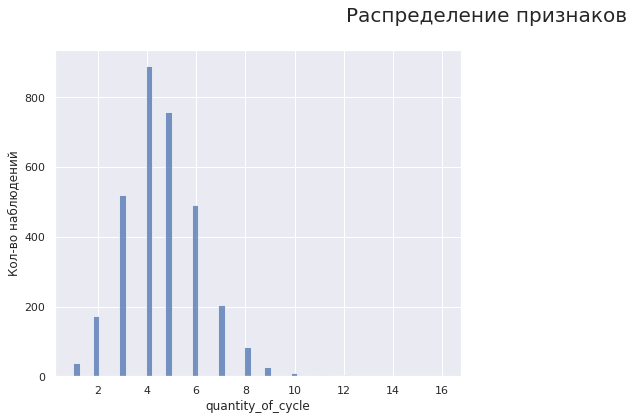

In [58]:
# Вызовем функцию построения гистограммы.
get_histplot(df_cycle)

Разброс количества включений дуги варьируется от 1 до 16. Интересно посмотреть, как количество нагреваний ковша соотносится с количеством легирующих материалов. 

In [59]:
df_bulk_copy = df_bulk.copy()
df_wire_copy = df_wire.copy()
df_gas_copy = df_gas.copy()

df_bulk_copy = df_bulk_copy.fillna(0)
df_wire_copy = df_wire_copy.fillna(0)

df_cycle = set_new_index(df_cycle)
df_bulk_copy = set_new_index(df_bulk_copy)
df_wire_copy = set_new_index(df_wire_copy)
df_gas_copy = set_new_index(df_gas_copy)

In [60]:
df_cycle_bulk_wire = df_cycle.join(df_bulk_copy).join(df_wire_copy).join(df_gas_copy)
df_cycle_bulk_wire.head(3)

,quantity_of_cycle,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9,Газ 1
1,5,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,29.749986
2,4,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.555561
3,5,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.554793


In [61]:
df_cycle_bulk_wire['bulk_sum'] = (df_cycle_bulk_wire['Bulk 1'] + 
                                  df_cycle_bulk_wire['Bulk 2'] +
                                  df_cycle_bulk_wire['Bulk 3'] +
                                  df_cycle_bulk_wire['Bulk 4'] +
                                  df_cycle_bulk_wire['Bulk 5'] +
                                  df_cycle_bulk_wire['Bulk 6'] +
                                  df_cycle_bulk_wire['Bulk 7'] +
                                  df_cycle_bulk_wire['Bulk 8'] +
                                  df_cycle_bulk_wire['Bulk 9'] +
                                  df_cycle_bulk_wire['Bulk 10'] +
                                  df_cycle_bulk_wire['Bulk 11'] +
                                  df_cycle_bulk_wire['Bulk 12'] +
                                  df_cycle_bulk_wire['Bulk 13'] +
                                  df_cycle_bulk_wire['Bulk 14'] +
                                  df_cycle_bulk_wire['Bulk 15'])

df_cycle_bulk_wire['wire_sum'] = (df_cycle_bulk_wire['Wire 1'] + 
                                  df_cycle_bulk_wire['Wire 2'] +
                                  df_cycle_bulk_wire['Wire 3'] +
                                  df_cycle_bulk_wire['Wire 4'] +
                                  df_cycle_bulk_wire['Wire 5'] +
                                  df_cycle_bulk_wire['Wire 6'] +
                                  df_cycle_bulk_wire['Wire 7'] +
                                  df_cycle_bulk_wire['Wire 8'] +
                                  df_cycle_bulk_wire['Wire 9'])

df_cycle_bulk_wire = df_cycle_bulk_wire.drop(['Bulk 1', 'Bulk 2', 'Bulk 3', 'Bulk 4', 
                                              'Bulk 5', 'Bulk 6', 'Bulk 7', 'Bulk 8', 
                                              'Bulk 9', 'Bulk 10', 'Bulk 11', 'Bulk 12',
                                              'Bulk 13', 'Bulk 14', 'Bulk 15', 'Wire 1', 
                                              'Wire 2', 'Wire 3', 'Wire 4', 'Wire 5', 
                                              'Wire 6', 'Wire 7', 'Wire 8', 'Wire 9'], axis=1)

df_cycle_bulk_wire.head(3)

,quantity_of_cycle,Газ 1,bulk_sum,wire_sum
1,5,29.749986,553.0,60.059998
2,4,12.555561,582.0,96.052315
3,5,28.554793,544.0,91.160157


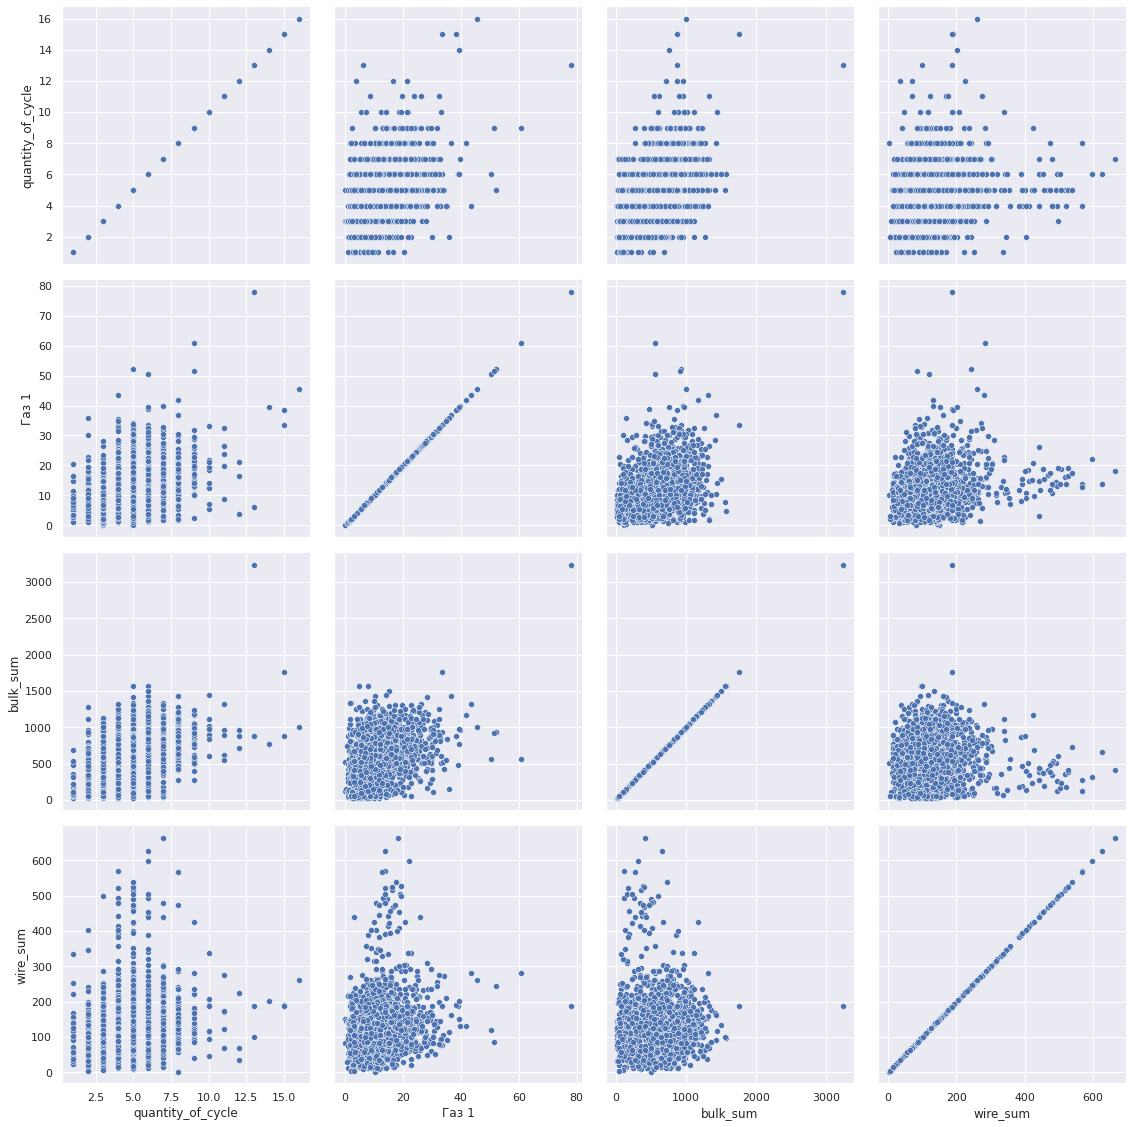

In [62]:
g = sns.PairGrid(df_cycle_bulk_wire, height=4)
g.map(sns.scatterplot)
plt.show()

На графиках мы отчетливо видим, что нет прямой зависимости между количеством включений нагревательной дуги и суммарным количеством легирующих материалов и газа.  

В начале исследования мы определились, что имеем дело не с рядом циклов легирования в каждой партии, а с одним полным циклом легирования каждой партии. Отсутствие зависимости между количеством нагреваний и количеством легирующих материалов и газа подтверждает правильность корректность этой установки.  

Обращает на себя внимание суммарное количество легирующих материалов и газа для партии(партий), в которой количество включений дуги находилось в пределах от 12 до 15. Возможно, тут мы имеем дело с локальным выбросом. 

### Датасет df_gas

In [63]:
# Загрузим общую информацию.
get_info(df_gas)

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692


,key,Газ 1
count,3239.000000,3239.000000
mean,1621.861377,11.002062
std,935.386334,6.220327
min,1.000000,0.008399
25%,812.500000,7.043089
50%,1622.000000,9.836267
75%,2431.500000,13.769915
max,3241.000000,77.995040


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB


В датасете не содержатся данные по двум партиям. Пропусков нет.

In [64]:
# Вызовем функцию проверки партий с пропущенными значениями.
gas_missing_batches_set = check_missing_batches(df_gas)
len(gas_missing_batches_set)

2

Посмотрим на распределение значений и выбросы.

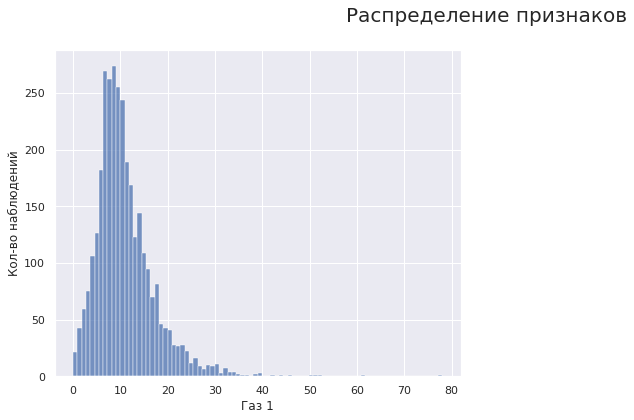

In [65]:
# Вызовем функцию построения гистограммы.
get_histplot(df_gas)

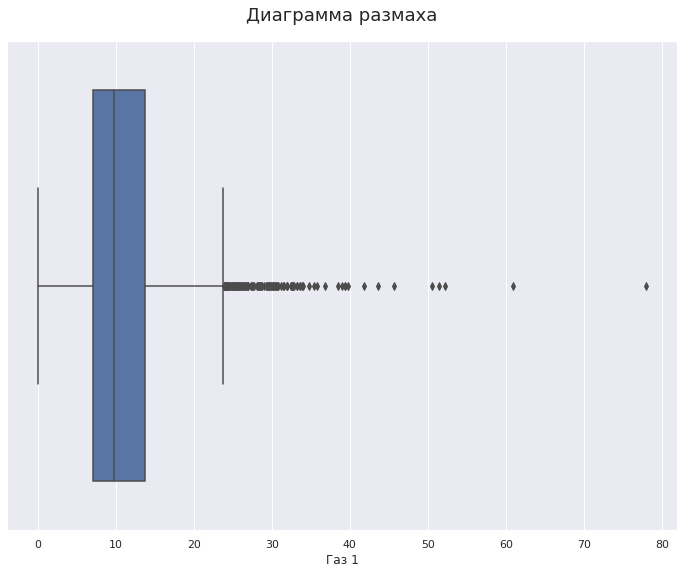

In [66]:
# Вызовем функцию построения диаграммы размаха.
get_boxplot(df_gas, 'Газ 1')

In [67]:
print(f'Граница правого выброса: {right_outlier(df_gas, "Газ 1")}')

Граница правого выброса: 23.9156272416


In [68]:
print(f'Длина правого хвоста: {df_gas[df_gas["Газ 1"] >= 23]["Газ 1"].count()}')

Длина правого хвоста: 141


В этом датасете пока наименьшее количество выбросов. Проверим его на экстремальные выбросы.

In [69]:
pd.DataFrame.from_dict(right_extreme_outlier(df_gas), # вызываем функцию рассчета экстремальных выбросов
                       orient='index', 
                       columns=['Экстремальный правый выборос'])   

,Экстремальный правый выборос
key,NaN
Газ 1,34.049878


In [70]:
print(f'Количество наблюдений с экстремальными выбросами: {df_gas[df_gas["Газ 1"] >= 34]["Газ 1"].count()}')

Количество наблюдений с экстремальными выбросами: 18


Зафиксируем партии с экстремальными выбросами.

In [71]:
gas_outliers_set = set(df_gas[df_gas["Газ 1"] >= 34]["key"])

В датасете df_gas мы получили 18 наблюдейний с экстремальными выбросами. Как их интерпретировать? Так как у нас нет методиста, который смог бы объяснить нюансы, техпроцесса мы не можем утверждать, что добавление в сплав того или иного количества газа должно быть статистически распределено нормально. Хотя бы потому, что металлургические комбинаты используют неоднородное сырье и допустим случай, когда сырье в одной из партий оказалось недостаточно качественным и для его обработки потребовалось больше газа.

В данных датасетах мы будем пользоваться "презумцией невиновности" для детектированных выбросов. Мы оставим их, а вот насколько они будут играть значимую роль для обучения модели, посмотрим по результатам обучения. И в процессе эксперемента сможем обнаружить те экстремальные выбросы, которые действительно являются таковыми и влияют на модель

### Датасет df_bulk

In [72]:
# Загрузим общую информацию.
get_info(df_bulk)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0


,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
count,3129.000000,252.000000,22.000000,1298.000000,1014.000000,77.000000,576.000000,25.000000,1.0,19.000000,176.000000,177.000000,2450.000000,18.000000,2806.000000,2248.000000
mean,1624.383509,39.242063,253.045455,113.879045,104.394477,107.025974,118.925347,305.600000,49.0,76.315789,83.284091,76.819209,260.471020,181.111111,170.284747,160.513345
std,933.337642,18.277654,21.180578,75.483494,48.184126,81.790646,72.057776,191.022904,NaN,21.720581,26.060347,59.655365,120.649269,46.088009,65.868652,51.765319
min,1.000000,10.000000,228.000000,6.000000,12.000000,11.000000,17.000000,47.000000,49.0,63.000000,24.000000,8.000000,53.000000,151.000000,16.000000,1.000000
25%,816.000000,27.000000,242.000000,58.000000,72.000000,70.000000,69.750000,155.000000,49.0,66.000000,64.000000,25.000000,204.000000,153.250000,119.000000,105.000000
50%,1622.000000,31.000000,251.500000,97.500000,102.000000,86.000000,100.000000,298.000000,49.0,68.000000,86.500000,64.000000,208.000000,155.500000,151.000000,160.000000
75%,2431.000000,46.000000,257.750000,152.000000,133.000000,132.000000,157.000000,406.000000,49.0,70.500000,102.000000,106.000000,316.000000,203.500000,205.750000,205.000000
max,3241.000000,185.000000,325.000000,454.000000,281.000000,603.000000,503.000000,772.000000,49.0,147.000000,159.000000,313.000000,1849.000000,305.000000,636.000000,405.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   Bulk 1   252 non-null    float64
 2   Bulk 2   22 non-null     float64
 3   Bulk 3   1298 non-null   float64
 4   Bulk 4   1014 non-null   float64
 5   Bulk 5   77 non-null     float64
 6   Bulk 6   576 non-null    float64
 7   Bulk 7   25 non-null     float64
 8   Bulk 8   1 non-null      float64
 9   Bulk 9   19 non-null     float64
 10  Bulk 10  176 non-null    float64
 11  Bulk 11  177 non-null    float64
 12  Bulk 12  2450 non-null   float64
 13  Bulk 13  18 non-null     float64
 14  Bulk 14  2806 non-null   float64
 15  Bulk 15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB


В датасете содержится много пропущенных значений. Нам известно, что в цикле легирования металла подается некоторое количество сыпучих веществ. Если значения нет, значит вещество не попадавалось, а следовательно мы можем все NaN заменить на нули. Сделаем это чуть позднее, а пока проверим датасет на партии с отсутствующими занчениями

In [73]:
# Вызовем функцию проверки партий с пропущенными значениями.
bulk_missing_batches_set = check_missing_batches(df_bulk)
len(bulk_missing_batches_set)

112

Посмотрим на распределение значений и выбросы.

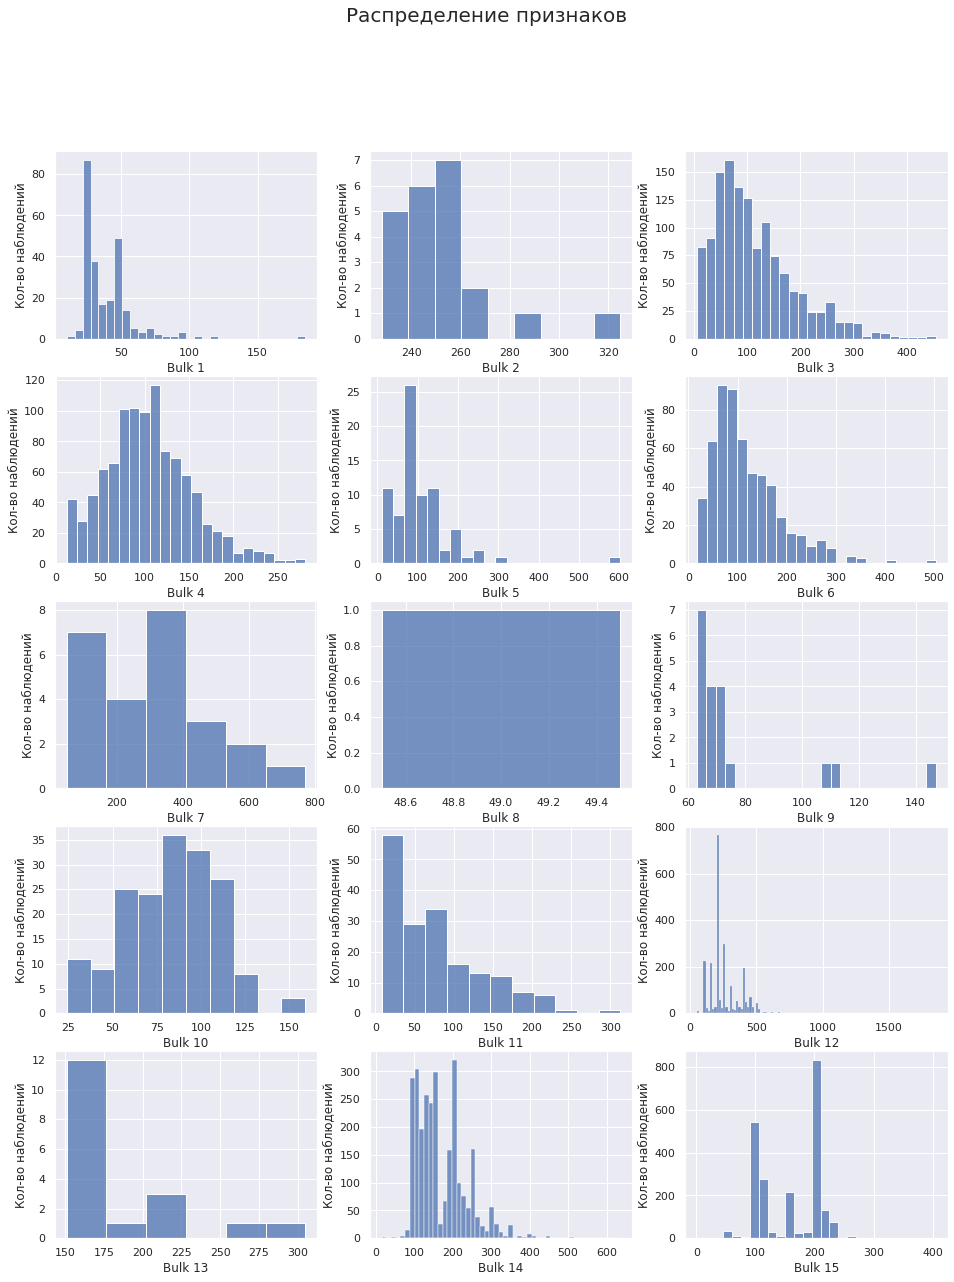

In [74]:
# Вызовем функцию построения гистограммы.
get_histplot(df_bulk)

Что видно:
- Признак Bulk 8 -- имеет всего одно значение;
- Признак Bulk 12 -- имеет очень длинный правый хвост;
- В целом все значения имееют разный разброс и форма этого разброса у каждого признака сама.
Нам необходимо посмотреть на этот датасет в целом. Для поиска аномалий привлечем алгоритм KNN.

In [75]:
df_bulk = df_bulk.fillna(0) # алгоритм не умеет работать с NaN, заменим их нулями.

data_bulk = df_bulk.drop('key', axis=1) # создадим тренировочный датасет.

model = KNN() # инициализируем модель.

estimation_knn = KNN().fit_predict(data_bulk) == 1 # обучим модель и получим предсказания.

outliers_knn = estimation_knn.sum() # суммируем предсказания.

print("Количество аномалий (KNN): ", outliers_knn)

df_bulk['outliers'] = estimation_knn # запишем в датасет полученные предсказания

# отфильтруем датасет по предсказаниям, чтобы получить партии, где алгоритм нашел аномалии.
bulk_outliers_set = set(df_bulk[df_bulk['outliers'] == 1]['key'].values )

len(bulk_outliers_set)

Количество аномалий (KNN):  313


/home/mikhail/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


313

313 аномалий в 313 партиях. Посмотрим, есть среди этих аномалий экстремальные выбросы.

Удалим признак 'Bulk 8', в котором всего одно значение, чтобы функция смогла расчитать квартили. И столбец "outliers".

In [76]:
df_bulk = df_bulk.drop(['Bulk 8', 'outliers'], axis=1)

In [77]:
pd.DataFrame.from_dict(right_extreme_outlier(df_bulk), # вызываем функцию рассчета экстремальных выбросов
                       orient='index', 
                       columns=['Экстремальный правый выборос'])   

,Экстремальный правый выборос
key,NaN
Bulk 1,10.0
Bulk 2,228.0
Bulk 3,323.0
Bulk 4,276.0
Bulk 5,11.0
Bulk 6,17.0
Bulk 7,47.0
Bulk 9,63.0
Bulk 10,24.0


In [78]:
pd.DataFrame.from_dict(left_extreme_outlier(df_bulk), # вызываем функцию рассчета экстремальных выбросов
                       orient='index', 
                       columns=['Экстремальный левый выборос'])   

,Экстремальный левый выборос
key,NaN
Bulk 1,NaN
Bulk 2,NaN
Bulk 3,NaN
Bulk 4,NaN
Bulk 5,NaN
Bulk 6,NaN
Bulk 7,NaN
Bulk 9,NaN
Bulk 10,NaN


Экстремальный правый выброс наблюдается в 13 признаках. К обработке этих признаков вернемся позднее. А пока зафиксируем партии, в которых встречаются эти выбросы

In [79]:
bulk_outliers_set = (set(df_bulk[df_bulk['Bulk 1'] >= 10]["key"]) |
                     set(df_bulk[df_bulk['Bulk 2'] >= 228]["key"]) |
                     set(df_bulk[df_bulk['Bulk 3'] >= 323]["key"]) |
                     set(df_bulk[df_bulk['Bulk 4'] >= 276]["key"]) |
                     set(df_bulk[df_bulk['Bulk 5'] >= 11]["key"]) |
                     set(df_bulk[df_bulk['Bulk 6'] >= 17]["key"]) |
                     set(df_bulk[df_bulk['Bulk 7'] >= 47]["key"]) |
                     set(df_bulk[df_bulk['Bulk 9'] >= 63]["key"]) |
                     set(df_bulk[df_bulk['Bulk 10'] >= 24]["key"]) |
                     set(df_bulk[df_bulk['Bulk 11'] >= 8]["key"]) |
                     set(df_bulk[df_bulk['Bulk 12'] >= 774]["key"]) |
                     set(df_bulk[df_bulk['Bulk 12'] >= 151]["key"]) |
                     set(df_bulk[df_bulk['Bulk 12'] >= 504]["key"])
                    )

### Датасет df_wire

In [80]:
# Загрузим общую информацию.
get_info(df_wire)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
count,3081.000000,3055.000000,1079.000000,63.000000,14.000000,1.000,73.000000,11.000000,19.000000,29.000000
mean,1623.426485,100.895853,50.577323,189.482681,57.442841,15.132,48.016974,10.039007,53.625193,34.155752
std,932.996726,42.012518,39.320216,99.513444,28.824667,NaN,33.919845,8.610584,16.881728,19.931616
min,1.000000,1.918800,0.030160,0.144144,24.148801,15.132,0.034320,0.234208,45.076721,4.622800
25%,823.000000,72.115684,20.193680,95.135044,40.807002,15.132,25.053600,6.762756,46.094879,22.058401
50%,1619.000000,100.158234,40.142956,235.194977,45.234282,15.132,42.076324,9.017009,46.279999,30.066399
75%,2434.000000,126.060483,70.227558,276.252014,76.124619,15.132,64.212723,11.886057,48.089603,43.862003
max,3241.000000,330.314424,282.780152,385.008668,113.231044,15.132,180.454575,32.847674,102.762401,90.053604


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   Wire 1  3055 non-null   float64
 2   Wire 2  1079 non-null   float64
 3   Wire 3  63 non-null     float64
 4   Wire 4  14 non-null     float64
 5   Wire 5  1 non-null      float64
 6   Wire 6  73 non-null     float64
 7   Wire 7  11 non-null     float64
 8   Wire 8  19 non-null     float64
 9   Wire 9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB


В датасете df_wire также содержится много пропущенных значений. Нам известно, что в цикле легирования металла подается некоторое количество проволоки. Если значения нет, значит проволока не попадавалась, а следовательно мы можем все NaN заменить на нули. Проверим датасет на партии с отсутствующими занчениями

In [81]:
# Вызовем функцию проверки партий с пропущенными значениями.
wire_missing_batches_set = check_missing_batches(df_wire)
len(wire_missing_batches_set)

160

Посмотрим на распределение значений и выбросы.

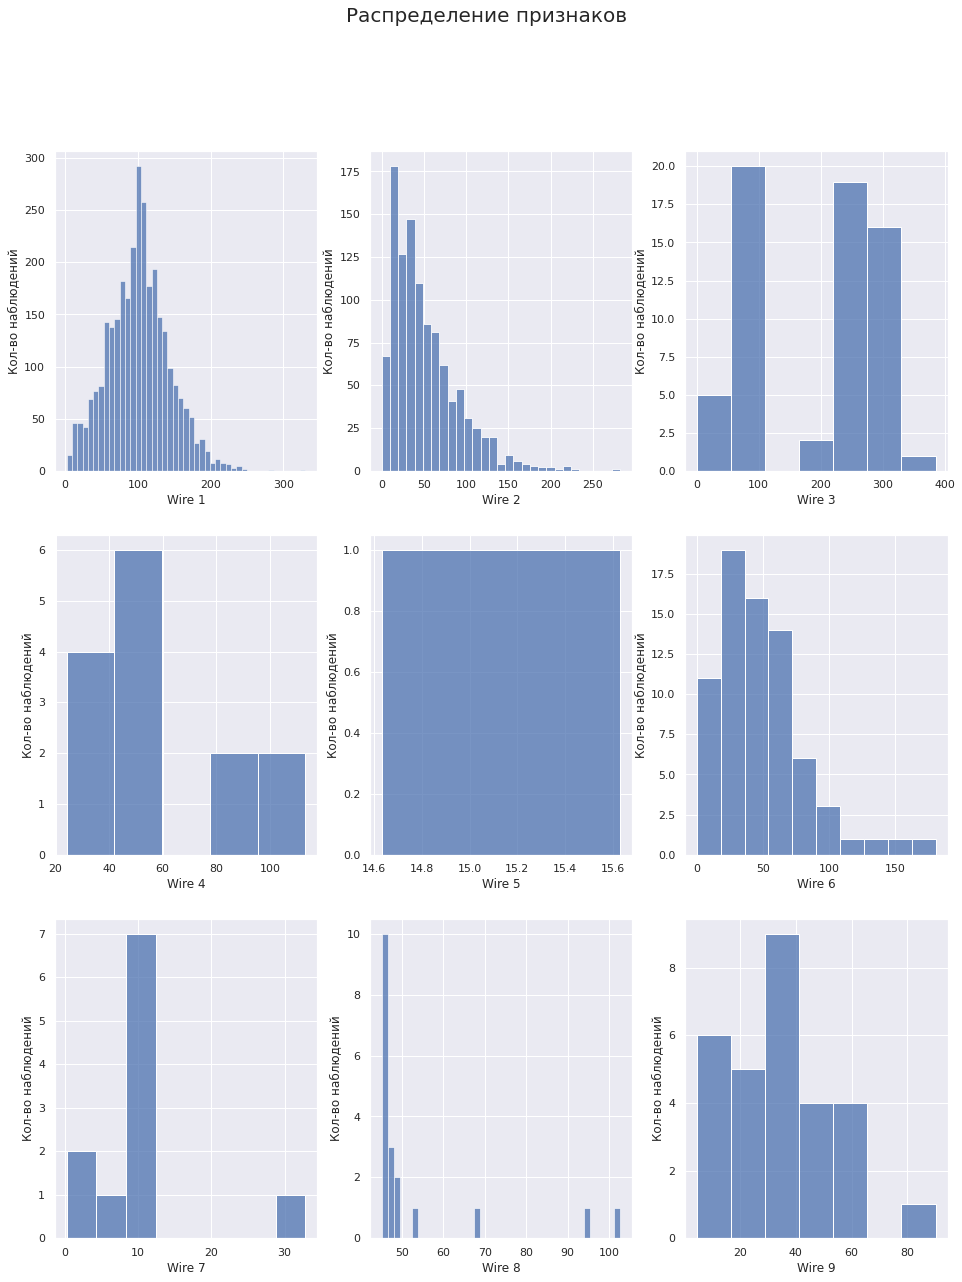

In [82]:
# Вызовем функцию построения гистограммы.
get_histplot(df_wire)

В признаке Wire 5 всего одно значение. Снова обратимся к алгоритму KNN для поиска аномалий.

In [83]:
df_wire = df_wire.fillna(0) # алгоритм не умеет работать с NaN, заменим их нулями.

data_wire = df_wire.drop('key', axis=1) # создадим тренировочный датасет.

model = KNN() # инициализируем модель.

estimation_knn = KNN().fit_predict(data_wire) == 1 # обучим модель и получим предсказания.

outliers_knn = estimation_knn.sum() # суммируем предсказания.

print("Количество аномалий (KNN): ", outliers_knn)

df_wire['outliers'] = estimation_knn # запишем в датасет полученные предсказания

# отфильтруем датасет по предсказаниям, чтобы получить партии, где алгоритм нашел аномалии.
wire_outliers_set = set(df_wire[df_wire['outliers'] == 1]['key'].values )
len(wire_outliers_set)

Количество аномалий (KNN):  308


/home/mikhail/.local/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function fit_predict is deprecated
  warnings.warn(msg, category=FutureWarning)


308

308 аномалий. Посмотрим, есть среди этих аномалий экстремальные выбросы. А перед этим удалим признак Wire 5, так как у него в датасете всего одно значение.

In [84]:
df_wire = df_wire.drop(['Wire 5', 'outliers'], axis=1)

In [85]:
pd.DataFrame.from_dict(right_extreme_outlier(df_wire), # вызываем функцию рассчета экстремальных выбросов
                       orient='index', 
                       columns=['Экстремальный правый выборос'])  

,Экстремальный правый выборос
key,NaN
Wire 1,330.314424
Wire 2,93.134079
Wire 3,0.144144
Wire 4,24.148801
Wire 6,0.034320
Wire 7,0.234208
Wire 8,45.076721
Wire 9,4.622800


In [86]:
pd.DataFrame.from_dict(left_extreme_outlier(df_wire), # вызываем функцию рассчета экстремальных выбросов
                       orient='index', 
                       columns=['Экстремальный левый выборос'])  

,Экстремальный левый выборос
key,NaN
Wire 1,NaN
Wire 2,NaN
Wire 3,NaN
Wire 4,NaN
Wire 6,NaN
Wire 7,NaN
Wire 8,NaN
Wire 9,NaN


Зафиксируем партии с экстремальными выбросами

In [87]:
wire_outliers_set = (set(df_wire[df_wire['Wire 1'] >= 330.314424]["key"]) |
                     set(df_wire[df_wire['Wire 2'] >= 93.134079]["key"]) |
                     set(df_wire[df_wire['Wire 3'] >= 0.144144]["key"]) |
                     set(df_wire[df_wire['Wire 4'] >= 24.148801]["key"]) |
                     set(df_wire[df_wire['Wire 6'] >= 0.034320]["key"]) |
                     set(df_wire[df_wire['Wire 7'] >= 0.234208]["key"]) |
                     set(df_wire[df_wire['Wire 8'] >= 45.076721]["key"]) |
                     set(df_wire[df_wire['Wire 9'] >= 4.622800]["key"])
                    )

В датасете df_wire, также как и в датасете df_bulk, мы получили правые экстремальные выбросы по всем признакам. И столкнулись с проблемой их интерпретации. Так как у нас нет методиста, который смог бы объяснить нюансы, техпроцесса мы **не можем утверждать**, что добавление в сплав тех или иных сыпучих материалов, или проволоки от партии к партии должно быть статистически распределено нормально. Например, хотя бы потому, что металлургические комбинаты используют неоднородное сырье и допустим случай, если сырье в одной из партий оказалось недостаточно качественным и для его обработки потребовалось больше проволоки и/или сыпучих материалов.   

В данных датасетах мы будем пользоваться "презумцией невиновности" для детектированных выбросов. Мы оставим их, а вот насколько они будут играть значимую роль для обучения модели, посмотрим по результатам обучения. И в процессе эксперемента сможем обнаружить те экстремальные выбросы, которые действительно являются таковыми и влияют на модель

### Датасет df_bulk_time

In [88]:
# Загрузим общую информацию.
get_info(df_bulk_time)

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56


,key
count,3129.000000
mean,1624.383509
std,933.337642
min,1.000000
25%,816.000000
50%,1622.000000
75%,2431.000000
max,3241.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   Bulk 1   252 non-null    object
 2   Bulk 2   22 non-null     object
 3   Bulk 3   1298 non-null   object
 4   Bulk 4   1014 non-null   object
 5   Bulk 5   77 non-null     object
 6   Bulk 6   576 non-null    object
 7   Bulk 7   25 non-null     object
 8   Bulk 8   1 non-null      object
 9   Bulk 9   19 non-null     object
 10  Bulk 10  176 non-null    object
 11  Bulk 11  177 non-null    object
 12  Bulk 12  2450 non-null   object
 13  Bulk 13  18 non-null     object
 14  Bulk 14  2806 non-null   object
 15  Bulk 15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB


Датасет содержит время подачи сыпучих материалов. По идее, в нем должно отсутствовать столько же партий с пустыми значениями, сколько и в датасете df_bulk. И все номера партий должны совпадать. Проверим это

In [89]:
# Вызовем функцию проверки партий с пропущенными значениями.
bulk_time_missing_batches_set = check_missing_batches(df_bulk_time)
len(bulk_time_missing_batches_set)

112

И узнаем, совпадают ли номера партий в двух датасетах.

In [90]:
bulk_time_missing_batches_set == bulk_missing_batches_set

True

Все сошлось.

### Датасет df_wire_time

In [91]:
# Загрузим общую информацию.
get_info(df_wire_time)

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,key
count,3081.000000
mean,1623.426485
std,932.996726
min,1.000000
25%,823.000000
50%,1619.000000
75%,2434.000000
max,3241.000000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   Wire 1  3055 non-null   object
 2   Wire 2  1079 non-null   object
 3   Wire 3  63 non-null     object
 4   Wire 4  14 non-null     object
 5   Wire 5  1 non-null      object
 6   Wire 6  73 non-null     object
 7   Wire 7  11 non-null     object
 8   Wire 8  19 non-null     object
 9   Wire 9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB


Датасет содержит время подачи проволоки. В нем должно отсутствовать столько же партий с пустыми значениями, сколько и в датасете df_wire. Все номера партий должны совпадать. 

In [92]:
# Вызовем функцию проверки партий с пропущенными значениями.
wire_time_missing_batches_set = check_missing_batches(df_wire_time)
len(wire_time_missing_batches_set)

160

In [93]:
wire_time_missing_batches_set == wire_missing_batches_set

True

## Предобработка данных

### Проверка целевого признака

Наша задача узнать, является ли последнее измерение температуры - действительно последним. Или после него в сплав добавляли легирующие материалы. В последнем случае, значением температуры мы не сможем считать корректным. И нам потребуется его удалить.

In [94]:
# Подготовим список столбцов для конвертации.
bulk_time_feature_list = list(df_bulk_time.columns)
bulk_time_feature_list.remove('key')

# Вызовем функцию конвертации типа данных.
convert_to_datetime(df_bulk_time, bulk_time_feature_list)

Проверка: datetime64[ns]
Проверка: datetime64[ns]
Проверка: datetime64[ns]
Проверка: datetime64[ns]
Проверка: datetime64[ns]
Проверка: datetime64[ns]
Проверка: datetime64[ns]
Проверка: datetime64[ns]
Проверка: datetime64[ns]
Проверка: datetime64[ns]
Проверка: datetime64[ns]
Проверка: datetime64[ns]
Проверка: datetime64[ns]
Проверка: datetime64[ns]
Проверка: datetime64[ns]


In [95]:
# Подготовим список столбцов для конвертации.
wire_time_feature_list = list(df_wire_time.columns)
wire_time_feature_list.remove('key')

# Вызовем функцию конвертации типа данных.
convert_to_datetime(df_wire_time, wire_time_feature_list)

Проверка: datetime64[ns]
Проверка: datetime64[ns]
Проверка: datetime64[ns]
Проверка: datetime64[ns]
Проверка: datetime64[ns]
Проверка: datetime64[ns]
Проверка: datetime64[ns]
Проверка: datetime64[ns]
Проверка: datetime64[ns]


In [96]:
# Запускаем функцию установки нового индекса.
df_bulk_time = set_new_index(df_bulk_time)
df_wire_time = set_new_index(df_wire_time)

In [97]:
# Объединяем датасеты.
df_bulk_wire = df_bulk_time.join(df_wire_time)

In [98]:
# Получаем таблицу с максимальным и минимальным временем добавления легирующих материалов.
df_bulk_wire_temp = pd.DataFrame(df_bulk_wire.max(axis=1), 
                                 columns=['max_time']).join(pd.DataFrame(df_bulk_time.min(axis=1),
                                                                         columns=['min_time'])
                                                               )
df_bulk_wire_temp.head(3)

,max_time,min_time
1,2019-05-03 11:21:30,2019-05-03 11:03:52
2,2019-05-03 11:46:38,2019-05-03 11:40:20
3,2019-05-03 12:31:06,2019-05-03 12:09:40


In [99]:
# Получим индексы, которые есть в обоих датасетах.
good_indexes = set(df_bulk_wire_temp.index) & set(min_max_temp.index)

# Получим индекы, которых нет в датасете min_max_temp.
tepm_wrong_indexes = set(min_max_temp.index) - good_indexes

# Удалим их из датасета min_max_temp.
min_max_temp = min_max_temp.drop(index=tepm_wrong_indexes)

# Получим индекы, которых нет в датасете df_bulk_min_max_temp.
bulk_wrong_indexes = set(df_bulk_wire_temp.index) - good_indexes

# Удалим из датасета df_bulk_min_max_temp.
df_bulk_wire_temp = df_bulk_wire_temp.drop(index=bulk_wrong_indexes)

# Контрольная проверка.
sum(min_max_temp.index == df_bulk_wire_temp.index) == len(good_indexes)

True

In [100]:
sum(min_max_temp['max_time'] < df_bulk_wire_temp['max_time'])

9

In [101]:
sum(min_max_temp['min_time'] > df_bulk_wire_temp['min_time'])

405

В 9 партиях после последнего измерения температуры в сплав были добавлены легирующие материалы. Целевой признак этих партий - некорректный. Мы его удалим.  

In [102]:
bulk_incorrect_measurements = set(min_max_temp[min_max_temp['max_time'] < df_bulk_wire_temp['max_time']].index) 
len(bulk_incorrect_measurements)

9

In [103]:
min_max_temp = min_max_temp.drop(index=bulk_incorrect_measurements)
len(min_max_temp)

2379

В 405 партиях добавление легирующих материалов произошло раньше первого измерения температуры. Удаление этих партий существенно сократит обучающий датасет. На наш взгляд, это допустимо, потому как первая температура так или иначе выражает начальное состояние сиситемы.

Проверим есть ли корреляция между начальной температурой и целевым признаком? Если корреляция высока, начальную температуру придется удалить из датасета, так как модель будет использовать ее в качестве подсказки.

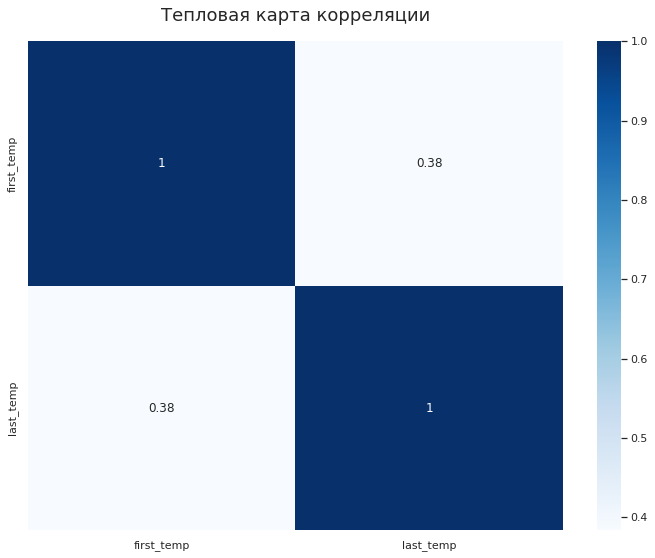

In [104]:
# Вызовем функцию построения тепловой карты корреляции.
get_correlation_map(min_max_temp)

Корреляция между начальной и конечной температурой - умеренна. Считаем, что использовать начальную температуру в качестве признака - допустимо

### Обработка датасетов

Обработаем датасет df_arc. Проверим признаки датасета на мультиколлениарность.

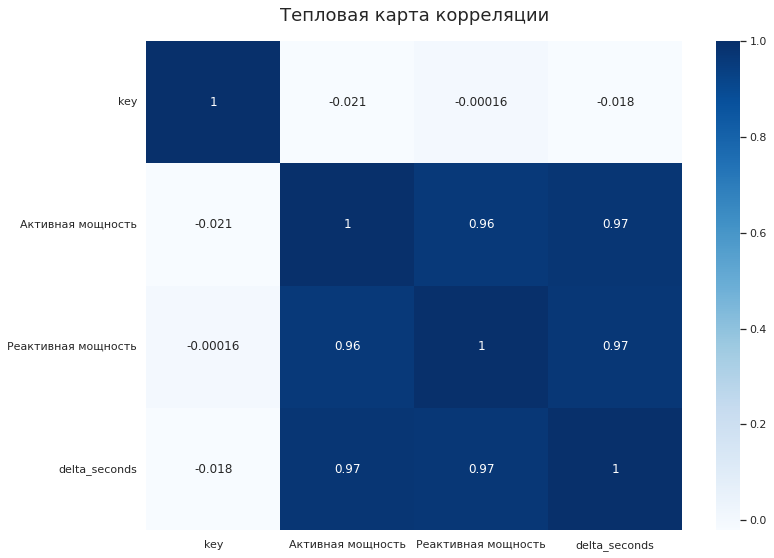

In [105]:
# Вызовем функцию построения тепловой карты корреляции.
get_correlation_map(df_arc)

Мы видим, что признаки "Активная мощность" и "Реактивная мощность" имеют сильную корреляцию. Мы оставим только один признак, "Активная мощность". Активная мощность измереяется в ваттах. А значит, по формуле W = P\*t мы сможем получить значение энергии. Далее это нам позволит агрегировать признаки в датасете df_arc путем суммирования.

In [106]:
# Переведем значения секунд в часы.
df_arc['delta_houres'] = df_arc['delta_seconds'] / 3600
df_arc['delta_houres'].head(5)

0    0.063333
1    0.051389
2    0.047778
3    0.101389
4    0.041111
Name: delta_houres, dtype: float64

In [107]:
# Получим значение энергии.
df_arc['energy'] = df_arc['Активная мощность'] * df_arc['delta_houres']
df_arc['energy'].head(5)

0    0.061817
1    0.041399
2    0.035564
3    0.168241
4    0.028480
Name: energy, dtype: float64

Введем в датасет среднее количество энергии, потраченное на легирование сплава в каждой партии. Среднее время, потраченное на легирование сплава в каждой партии. И добавим для удобства суммарное количество циклов.

In [108]:
func = {'energy': ['sum', 'mean'],
        'delta_houres':['sum', 'mean'],
        'key':['count']}

df_arc_final = df_arc.groupby(['key']).agg(func)

# Избавляемся от мульти индекса.
df_arc_final.columns = ["_".join(a) for a in df_arc_final.columns.to_flat_index()]
df_arc_final.index.name=None

df_arc_final.head(3)

,energy_sum,energy_mean,delta_houres_sum,delta_houres_mean,key_count
1,0.335501,0.067100,0.305000,0.061000,5
2,0.203838,0.050959,0.225278,0.056319,4
3,0.123218,0.024644,0.181944,0.036389,5


Проведем еще одну проверку на мультиколлениарность.

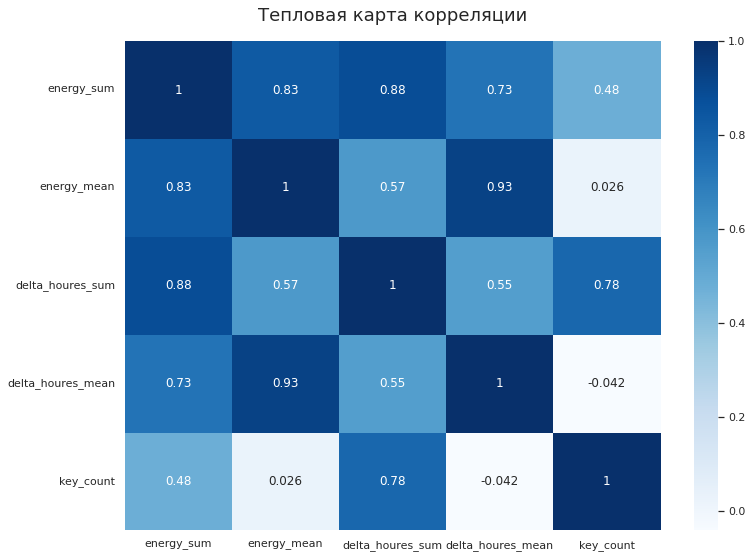

In [109]:
# Вызовем функцию построения тепловой карты корреляции.
get_correlation_map(df_arc_final)

In [110]:
# Удалим признаки, с сильной корреляцией.
df_arc_final = df_arc_final.drop(['energy_sum', 'delta_houres_mean'], axis=1)
df_arc_final.head(3)

,energy_mean,delta_houres_sum,key_count
1,0.067100,0.305000,5
2,0.050959,0.225278,4
3,0.024644,0.181944,5


### Сбор финального датасета

In [111]:
# Вызываем функцию установки нового индекса.
df_gas_final = set_new_index(df_gas)
df_gas_final.head(3)

,Газ 1
1,29.749986
2,12.555561
3,28.554793


In [112]:
# Вызываем функцию установки нового индекса.
df_bulk_final = set_new_index(df_bulk)
df_bulk_final.head(3)

,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
1,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0
2,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0
3,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0


In [113]:
# Вызываем функцию установки нового индекса.
df_wire_final = set_new_index(df_wire)
df_wire_final.head(3)

,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
1,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,91.160157,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Отберем партии, которые присутствуют во всех датасетах

In [114]:
# Соберем партии с пропущенными значениями в каждом датасете.
lost_batches = (temp_missing_batches_set |
                arc_missing_batches_set |
                gas_missing_batches_set |
                bulk_missing_batches_set |
                wire_missing_batches_set)
len(lost_batches)

219

In [115]:
good_indexes = (set(min_max_temp.index) &
                 set(df_arc.index) &
                 set(df_gas.index) &
                 set(df_bulk.index)&
                 set(df_wire.index))
print(len(good_indexes)) # эти индексы есть во всех партиях.

bad_indexes = (set(range(1, 3242)) - good_indexes) | lost_batches
print(len(bad_indexes)) # эти индексы есть не во всех партиях.

2379
925


In [116]:
# Вызовем функцию удаления "бракованных" партий.
min_max_temp = del_batches(min_max_temp, bad_indexes)
len(min_max_temp)

2316

In [117]:
# Вызовем функцию удаления "бракованных" партий.
df_arc_final = del_batches(df_arc_final, bad_indexes)
len(df_arc_final)

2316

In [118]:
# Вызовем функцию удаления "бракованных" партий.
df_gas_final = del_batches(df_gas_final, bad_indexes)
len(df_gas_final)

2316

In [119]:
# Переименнуем колонку.
df_gas_final.rename(columns={'Газ 1': 'gas'}, inplace=True)

In [120]:
# Вызовем функцию удаления "бракованных" партий.
df_bulk_final = del_batches(df_bulk_final, bad_indexes)
len(df_bulk_final)

2316

In [121]:
# Вызовем функцию удаления "бракованных" партий.
df_wire_final = del_batches(df_wire_final, bad_indexes)
len(df_wire_final)

2316

Теперь объединим все датасеты в один.

In [122]:
df_final = (min_max_temp
            .join(df_arc_final)
            .join(df_gas_final)
            .join(df_bulk_final)
            .join(df_wire_final)
           )

df_final.shape

(2316, 30)

In [123]:
df_final.head(3)

,min_time,first_temp,max_time,last_temp,energy_mean,delta_houres_sum,key_count,gas,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
1,2019-05-03 11:16:18,1571.0,2019-05-03 11:30:39,1613.0,0.067100,0.305000,5,29.749986,0.0,0.0,0.0,43.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,150.0,154.0,60.059998,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-05-03 11:37:27,1581.0,2019-05-03 11:59:12,1602.0,0.050959,0.225278,4,12.555561,0.0,0.0,0.0,73.0,0.0,0.0,0.0,0.0,0.0,0.0,206.0,0.0,149.0,154.0,96.052315,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-05-03 12:13:17,1596.0,2019-05-03 12:34:57,1599.0,0.024644,0.181944,5,28.554793,0.0,0.0,0.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,205.0,0.0,152.0,153.0,91.160157,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Удалим ненужные столбцы 'time_min', 'time_max'.

In [124]:
df_final = df_final.drop(['min_time', 'max_time'], axis=1)

### Работа с выбросами

В каждом датасете мы фиксировали партии с экстремальными выбросами. Посмотрим, есть ли такие, которые совпдают во всех датасетах.

In [125]:
batches_outliers_set = (temp_outliers_set &
                        arc_outliers_set &
                        gas_outliers_set &
                        bulk_outliers_set &
                        wire_outliers_set)
len(batches_outliers_set)

0

Таких нет. Теперь мы вернемся к количеству цикла в партиях. Мы наблюдали существенные выбросы в партиях с количеством циклов от 12 до 15. Посмотрим на них.

In [126]:
df_final[df_final['key_count'] >= 12]

,first_temp,last_temp,energy_mean,delta_houres_sum,key_count,gas,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15,Wire 1,Wire 2,Wire 3,Wire 4,Wire 6,Wire 7,Wire 8,Wire 9
44,1600.0,1603.0,0.054730,0.573056,12,21.265271,0.0,0.0,0.0,0.0,0.0,88.0,0.0,0.0,0.0,0.0,159.0,154.0,321.0,159.0,69.189123,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
46,1607.0,1612.0,0.070896,0.810833,13,6.118441,0.0,0.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.0,204.0,0.0,401.0,204.0,100.245593,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
322,1619.0,1616.0,0.052210,0.738333,13,77.995040,185.0,0.0,101.0,58.0,0.0,0.0,406.0,0.0,0.0,0.0,1849.0,0.0,636.0,0.0,0.000000,188.228550,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1513,1553.0,1574.0,0.038140,0.701667,15,38.471706,0.0,0.0,200.0,0.0,0.0,220.0,0.0,0.0,0.0,21.0,157.0,0.0,180.0,103.0,130.197596,60.229519,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1689,1583.0,1606.0,0.159712,1.163611,15,33.597044,0.0,0.0,0.0,0.0,0.0,247.0,0.0,0.0,0.0,0.0,733.0,305.0,248.0,224.0,187.153206,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
1829,1535.0,1590.0,0.026658,0.418056,12,3.785225,0.0,0.0,0.0,0.0,0.0,142.0,0.0,0.0,0.0,0.0,313.0,0.0,298.0,210.0,36.082798,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0
2108,1639.0,1541.0,0.047157,0.760833,16,45.638999,63.0,242.0,0.0,98.0,94.0,0.0,507.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.051040,0.000000,93.213127,92.570401,63.045845,1.053936,0.0,0.0


Обращают на себя внимание две партии: 1689, у которой запредельное значение в признаках: energy_mean и delta_houres_sum, и партия 322, у которой запредельное значение в признаке Bulk 12. Удалим из датасета эти две партии.

In [127]:
rem_list = [322, 1689]
df_final = del_batches(df_final, rem_list)
df_final.shape

(2314, 28)

### Корреляция

Проверим датасет на мультиколлениарность

In [128]:
corr_table = df_final.corr()

for column in corr_table.columns:
    for row in corr_table.columns:
        value = corr_table[column][row]
        if value != 1 and value > 0.8:
            print(f'{column}----{row}----{value}')

Bulk 9----Wire 8----0.9749678216068455
Wire 8----Bulk 9----0.9749678216068455


In [129]:
# Удалим столбцы, чей коэффициент корреляции превышает 0.9, т.е. является очень высоким.
df_final = df_final.drop(['Bulk 9'], axis=1)
df_final.shape

(2314, 27)

В датасете остались признаки с высокой корреляцией: от 0.7 до 0.8. В случае, если модель будет показывать плохое качество, удалим их.

### Подготовка датасета к обучению

In [130]:
# Вызываем функцию разбивки датасета на обучающую и тестовые выборки.
X_train, X_test, y_train, y_test = data_preparation(df_final)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1735, 26)
(579, 26)
(1735,)
(579,)


## Обучение

### LinearRegression

In [131]:
# Создадим модель.
model_lr = LinearRegression().fit(X_train, y_train)

# Проведем обучение с валидацией.
scores = cross_val_score(model_lr, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)

# Получим предсказания на тестовой выборке.
pred_test = model_lr.predict(X_test)

# Получим mae на тестовой выборке.
lr_mae_test = mean_absolute_error(y_test, pred_test)
    
scores = -1 * scores

# Получим лучшую оценку mae на обучении с валидацией.
lr_best_score = scores.min()

print('Оценки модели:', scores)
print('Усредненная оценка:', scores.sum() / 5)
print('Лучшая оценка:', lr_best_score)

print()
print(f'MAE на тестовой выборке - {lr_mae_test}')

Оценки модели: [6.06848403 6.52827549 6.24734835 6.66460571 6.07248995]
Усредненная оценка: 6.316240707504049
Лучшая оценка: 6.068484032198861

MAE на тестовой выборке - 6.152070967641424


### CatBoost

In [132]:
# Обучим Catboost.
cat = CatBoostRegressor(loss_function='MAE',
                         random_state=42,
                         iterations=200,
                         verbose=0).fit(X_train, y_train)
#Получим предсказания.
pred_test = cat.predict(X_test)
cat_mae_test = mean_absolute_error(y_test, pred_test)


print(f'Обучение: {cat.get_best_score()}')
print(f'MAE на тестовой выборке - {cat_mae_test}')

Обучение: {'learn': {'MAE': 5.052527968225512}}
MAE на тестовой выборке - 5.938625166368526


### Lightgbm

In [133]:
train_data = lightgbm.Dataset(X_train, 
                              label=y_train, 
                              free_raw_data=False)

test_data = lightgbm.Dataset(X_test, 
                             label=y_test)

param_grid = {'learning_rate': [0.01, 0.1, 0.3, 0.5, 0.7, 1],
              'max_depth': [15, 20, 30, 35, 100],
             }

lgbm = lightgbm.LGBMRegressor()

grid_search = GridSearchCV(estimator = lgbm, 
                           param_grid = param_grid, 
                           cv = 5,
                           n_jobs = -1, 
                           scoring = 'neg_mean_absolute_error',
                          )
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5, 0.7, 1],
                         'max_depth': [15, 20, 30, 35, 100]},
             scoring='neg_mean_absolute_error')

In [134]:
predictions = grid_search.best_estimator_.predict(X_test)
mae_lgbm = mean_absolute_error(y_test, predictions)

print(grid_search.best_params_)
print()
print(f'MAE для LightGBM модели на обучающей выборке: {(-grid_search.best_score_)}')
print(f'MAE для LightGBM модели на тестовой выборке: {mae_lgbm}')

{'learning_rate': 0.1, 'max_depth': 15}

MAE для LightGBM модели на обучающей выборке: 6.392210854347314
MAE для LightGBM модели на тестовой выборке: 6.146307972761663


### RandomForestRegressor

In [135]:
model_rfr = RandomForestRegressor(random_state=42)
score = 'neg_mean_absolute_error' 

param_grid = {
    "n_estimators": [400],
    'max_depth': [10, 30, 50]
}

gs = GridSearchCV(model_rfr, 
                  param_grid, 
                  scoring=score, 
                  cv=5,
                  n_jobs=-1)

gs.fit(X_train, y_train)
best_score = -1 * gs.best_score_

print(f'Лучшие гиперпараметры: {gs.best_params_}')
print(f'Лучшее значение MAE на обучении: {best_score}')

predictions = gs.predict(X_test)
mae = mean_absolute_error(y_test, predictions)

print(f'Лучшее значение MAE на тесте: {mae}')

Лучшие гиперпараметры: {'max_depth': 50, 'n_estimators': 400}
Лучшее значение MAE на обучении: 6.215811239193085
Лучшее значение MAE на тесте: 6.027949050086353


### Feature importance

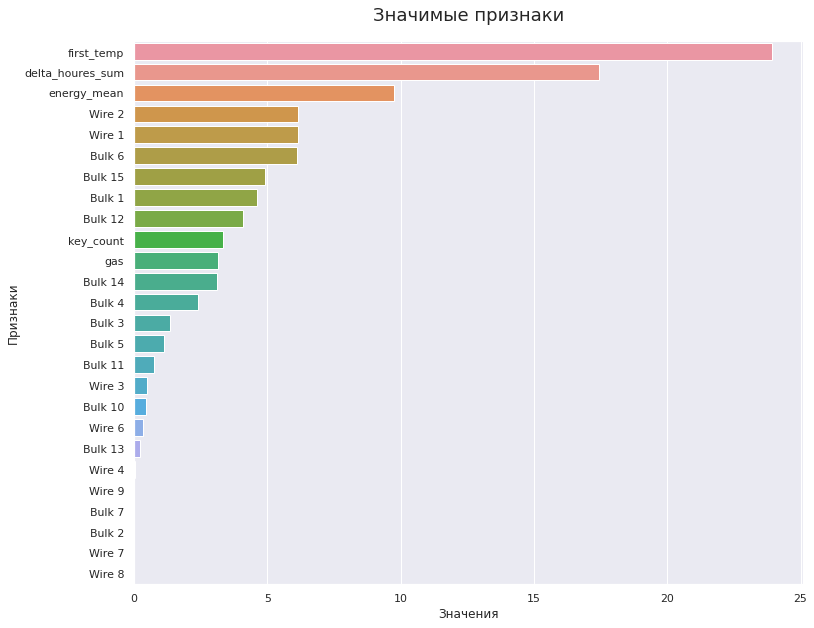

In [136]:
# Вызовем функции построения графика важности признаков.
barplot_feature_importance(cat.get_feature_importance(),X_train.columns,'Catboost')

## Доработка данных

Удалим из датасета записи, в которых количество циклов нагрева превышает 12.

In [137]:
df_final_modified = df_final[df_final['key_count'] <= 12]

Удалим из датасета признаки, которые Catboost посчитал несущественными.

In [138]:
df_final_modified = df_final_modified.drop(['Bulk 10', 'Bulk 11', 'Wire 7', 
                                            'Wire 3', 'Bulk 13', 'Bulk 5', 
                                            'Bulk 2', 'Wire 6', 'Wire 8', 'Wire 9'], axis=1)

In [139]:
df_final_modified.shape

(2311, 17)

## Повторное обучение

In [140]:
# Вызываем функцию разбивки датасета на обучающую и тестовые выборки.
X_train, X_test, y_train, y_test = data_preparation(df_final_modified)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1733, 16)
(578, 16)
(1733,)
(578,)


### LinearRegression

In [141]:
# Создадим модель.
model_lr = LinearRegression().fit(X_train, y_train)

# Проведем обучение с валидацией.
scores = cross_val_score(model_lr, X_train, y_train, scoring='neg_mean_absolute_error', cv=5)

# Получим предсказания на тестовой выборке.
pred_test = model_lr.predict(X_test)

# Получим mae на тестовой выборке.
lr_mae_test = mean_absolute_error(y_test, pred_test)
    
scores = -1 * scores

# Получим лучшую оценку mae на обучении с валидацией.
lr_best_score = scores.min()

print('Оценки модели:', scores)
print('Усредненная оценка:', scores.sum() / 5)
print('Лучшая оценка:', best_score)

print()
print(f'MAE на тестовой выборке - {lr_best_score}')

Оценки модели: [6.34123623 6.8099174  5.768485   6.39630401 6.11679089]
Усредненная оценка: 6.286546707368699
Лучшая оценка: 6.215811239193085

MAE на тестовой выборке - 5.768485002243374


### CatBoost

In [142]:
# Обучим Catboost.
cat = CatBoostRegressor(loss_function='MAE',
                         random_state=42,
                         iterations=200,
                         verbose=0).fit(X_train, y_train)
#Получим предсказания.
pred_test = cat.predict(X_test)
cat_mae_test = mean_absolute_error(y_test, pred_test)


print(f'Обучение: {cat.get_best_score()}')
print(f'MAE на тестовой выборке - {cat_mae_test}')

Обучение: {'learn': {'MAE': 5.094468032999902}}
MAE на тестовой выборке - 5.541385589555616


### Lightgbm

In [143]:
train_data = lightgbm.Dataset(X_train, 
                              label=y_train, 
                              free_raw_data=False)

test_data = lightgbm.Dataset(X_test, 
                             label=y_test)

param_grid = {'learning_rate': [0.01, 0.1, 0.3, 0.5, 0.7, 1],
              'max_depth': [15, 20, 30, 35, 100],
             }

lgbm = lightgbm.LGBMRegressor()

grid_search = GridSearchCV(estimator = lgbm, 
                           param_grid = param_grid, 
                           cv = 5,
                           n_jobs = -1, 
                           scoring = 'neg_mean_absolute_error',
                          )
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LGBMRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.3, 0.5, 0.7, 1],
                         'max_depth': [15, 20, 30, 35, 100]},
             scoring='neg_mean_absolute_error')

In [144]:
predictions = grid_search.best_estimator_.predict(X_test)
mae_lgbm = mean_absolute_error(y_test, predictions)

print(grid_search.best_params_)
print()
print(f'MAE для LightGBM модели на обучающей выборке: {(-grid_search.best_score_)}')
print(f'MAE для LightGBM модели на тестовой выборке: {mae_lgbm}')

{'learning_rate': 0.1, 'max_depth': 15}

MAE для LightGBM модели на обучающей выборке: 6.415366951261641
MAE для LightGBM модели на тестовой выборке: 6.03298041631147


### RandomForestRegressor

In [145]:
model_rfr = RandomForestRegressor(random_state=42)
score = 'neg_mean_absolute_error' 

param_grid = {
    "n_estimators": [400],
    'max_depth': [10, 30, 50]
}

gs = GridSearchCV(model_rfr, 
                  param_grid, 
                  scoring=score, 
                  cv=5,
                  n_jobs=-1)

gs.fit(X_train, y_train)
best_score = -1 * gs.best_score_

print(f'Лучшие гиперпараметры: {gs.best_params_}')
print(f'Лучшее значение MAE на обучении: {best_score}')

predictions = gs.predict(X_test)
mae = mean_absolute_error(y_test, predictions)

print(f'Лучшее значение MAE на тесте: {mae}')

Лучшие гиперпараметры: {'max_depth': 10, 'n_estimators': 400}
Лучшее значение MAE на обучении: 6.296365607451703
Лучшее значение MAE на тесте: 5.673086893604853


## Итоги

Результаты обучения первичного датасета.

In [146]:
pd.DataFrame({'model':['LinarRegression', 
                       'Catboost', 
                       'LightGBM',
                       'RandomForestRegressor'],
              'mae_train':[6.06,
                           5.05, 
                           6.39, 
                           6.21],
              'mae_test':[6.15,
                          5.93, 
                          6.14, 
                          6.02]})

,model,mae_train,mae_test
0,LinarRegression,6.06,6.15
1,Catboost,5.05,5.93
2,LightGBM,6.39,6.14
3,RandomForestRegressor,6.21,6.02


Результаты обучения модифицированного датасета.

In [147]:
pd.DataFrame({'model':['LinarRegression', 
                       'Catboost', 
                       'LightGBM',
                       'RandomForestRegressor'],
              'mae_train':[6.21,
                           5.09, 
                           6.41, 
                           6.29],
              'mae_test':[5.76,
                          5.54, 
                          6.03, 
                          5.67]})

,model,mae_train,mae_test
0,LinarRegression,6.21,5.76
1,Catboost,5.09,5.54
2,LightGBM,6.41,6.03
3,RandomForestRegressor,6.29,5.67


## Отчет

**Какие пункты плана были выполнены, а какие — нет (поясните почему)?**  
Первоначальный план состоял в том, чтобы выбрать из датасета целевой признак, проверить его корректность, очистить датасет от выбросов, проверить корреляцию и получить более менее вменяемую модель. Но первые эксперементы показали низкое качество предсказаний до удаления выбросов, mae в районе 7 и нестабильные предсказания после удаления выбросов. На этом шаге датасет сжался до 1500 значений и при изменении random_state давал выборку на тесте с разницей в 0.5, что свидетельствовало скорее об удачном разделении выборки, а качество самой модели в этом случае - оставляло желать лучшего. По этой причине взгляд на решение задачи был пересмотрен. И первоначальный план изменен.

**Какие трудности возникли и как вы их преодолели?**  
После первой неудачной попытки были рассмотрены три подхода к решению задачи:
1. Увеличить количество целевых признаков;
2. Добавить в датасет новые признаки;
3. Отказаться от борьбы с выбросами.

Первое решение могло быть реализовано, если бы существовало доказательство, что в каждой партии датасета представлен не один цикл легирования, а несколько. Основаная трудность состояла в проверке данной гипотезы. Попытка написать код, который бы "разложил все по полочкам" не увенчалась успехом. Не хватило знаний в программировании и времени. По этой причине проверка проводилась "дедушкиным способом", глазами. Анализировались несколько рандомных партий. Чуть позже пришла идея посмотреть на эту проблему с другой стороны и построить график зависимости между циклами нагрева и количеством легирующих компонентов. Если бы они нарастали в зависимости от роста циклов нагрева, мы бы получили доказательство, что внутри каждой партии данные о нескольких циклах легирования. График показал обратное, но идея была отличной, потому как сэкономила время и подтвердила догадки.

Второе решение в итоге было реализовано. Через добавления в обучающую выборку времени начала цикла легирования. Тут была единственная трудность: более 400 показателей температуры не подходили под строгое определение "начало легирования". Перед этими замерами в сплав уже были добавлены компоненты. Так как удаление 400 наблюдений привело бы к сжатию датасета и модели, которая угадывает случайно, возник вопрос, насколько корректно их оставить? Рассуждения и осмысливание этого вопроса заняли много времени. В итоге, аргументация в пользу того, что эти данные необходимо оставить пересилила желание их удались.

Третье решение было опробовано и не дало нужного результата. В датасете присутствуют много выбросов, но как показали эксперементы не все они влияют на качество модели. Что убирать, а что оставлять в итоге было подобрано руками

**Какие ключевые шаги в решении задачи выделили?**  
Ключевые шаги были описаны в курсе, который мы прошли: анализ данных, обработка данных, обучение, анализ результатов, повторная работа с данными, повторное обучение, анализ результатов.

**Какая ваша итоговая модель и какое у неё качество?**  
Задача была решена с помощью 4 моделей. Лучшее качество показал CatBoost. На трейне он выдал mae 5.05, 5.93. После удаления малозначимых признаков части выбросов результат на трейне немного ухудшился до 5.09, а на тесте, напротив, вырос до 5.54. С учетом скорости работы именно эту модель мы могли бы предложить заказчику. 